<a href="https://colab.research.google.com/github/jduell12/DS-Unit-2-Linear-Models/blob/master/C_213_guided_project_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Model Building
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For running this notebook either locally or in colab
import sys

In [2]:
%%capture
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
# For encoding categorical data
from category_encoders import OneHotEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# NYC Rent

**GOAL:** Improve our model for predicting NYC rent prices.

**Objectives**

- Do one-hot encoding of categorical features
- Do univariate feature selection
- Use scikit-learn to fit Ridge Regression models

# I. Wrangle Data

Create **wrangle function** for **reproducibility**.

In [41]:
def wrangle(filepath):
  df = pd.read_csv(filepath, parse_dates=['created'], index_col='created').sort_index()
  
  # Remove outlier observations
  df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
          (df['price'] <= np.percentile(df['price'], 99.5)) & 
          (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
          (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
          (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
          (df['longitude'] <= np.percentile(df['longitude'], 99.95))]
  # drop high cardinality categorical variables 
  hcc_cutoff = 3
  drop_cols = [col for col in df.select_dtypes('object').columns if df[col].nunique() > hcc_cutoff]
  df = df.drop(columns=drop_cols)
  return df

df = wrangle(DATA_PATH+'apartments/renthop-nyc.csv')

In [30]:
df.shape

(48817, 30)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48817 entries, 2016-04-01 22:12:41 to 2016-06-29 21:41:47
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             48817 non-null  float64
 1   bedrooms              48817 non-null  int64  
 2   latitude              48817 non-null  float64
 3   longitude             48817 non-null  float64
 4   price                 48817 non-null  int64  
 5   interest_level        48817 non-null  object 
 6   elevator              48817 non-null  int64  
 7   cats_allowed          48817 non-null  int64  
 8   hardwood_floors       48817 non-null  int64  
 9   dogs_allowed          48817 non-null  int64  
 10  doorman               48817 non-null  int64  
 11  dishwasher            48817 non-null  int64  
 12  no_fee                48817 non-null  int64  
 13  laundry_in_building   48817 non-null  int64  
 14  fitness_center        48817 non-nul

In [42]:
df.head()

,bathrooms,bedrooms,latitude,longitude,price,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-01 22:12:41,1.0,1,40.7302,-73.9924,3195,high,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:56:00,1.0,0,40.7576,-73.9677,2000,medium,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:57:15,2.0,3,40.7388,-73.9851,5850,high,1,1,0,1,1,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2016-04-01 23:26:07,1.0,1,40.7939,-73.9738,2745,medium,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2016-04-02 00:48:13,1.0,1,40.7784,-73.9491,2400,medium,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
df.select_dtypes('object').nunique()

description        37853
display_address     8674
street_address     15135
interest_level         3
dtype: int64

In [23]:
# for loop option for high cardinality categorical cols
# drop_cols = []
# for col in df.select_dtypes('object').columns:
#   if df[col].nunique() > 3:
#     drop_cols.append(col)

# print(drop_cols)

['description', 'display_address', 'street_address']


In [40]:
# list comprehension for high cardinality categorical cols
# hcc_cutoff = 3
# drop_cols = [col for col in df.select_dtypes('object').columns if df[col].nunique() > hcc_cutoff]
# drop_cols

['description', 'display_address', 'street_address']

# II. Split Data

Split **target vector** from **feature matrix**.

In [44]:
target = 'price'
X = df.drop(columns=target)
y = df[target]  

Split data into **training** and **test** sets.

(Use data from April & May 2016 to train. Use data from June 2016 to test.)

In [55]:
# Option 1: Choose a cutoff
cutoff = '2016-06-01'
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [56]:
len(X_train)

31844

In [77]:
# Option 2: Sort index and use iloc
# find the length of the df and cutoff from the index row 
# need to make sure that the index is sorted 
cutoff = int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

In [59]:
len(X_train)

39053

In [60]:
X_train.head()

,bathrooms,bedrooms,latitude,longitude,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-01 22:12:41,1.0,1,40.7302,-73.9924,high,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:56:00,1.0,0,40.7576,-73.9677,medium,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:57:15,2.0,3,40.7388,-73.9851,high,1,1,0,1,1,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2016-04-01 23:26:07,1.0,1,40.7939,-73.9738,medium,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2016-04-02 00:48:13,1.0,1,40.7784,-73.9491,medium,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# III. Establish Baseline

**Note:** This is a **regression** problem because we're predictiong the continuous value `'price'`.

In [61]:
y_pred = [y_train.mean()] * len(y_train)
print('Mean price:', y_train.mean())
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Mean price: 3575.604007034292
Baseline MAE: 1201.8811133682555


# IV. Build Models

**Question:** How can we represent *categorical* features numerically so that we can use them to train our model?

In [71]:
# Step 1: Import transformer class
# Did above

# Step 2: Instantiate transformer
ohe = OneHotEncoder(use_cat_names=True)

# Step 3: Fit transformer to TRAINING data
ohe.fit(X_train)

# Step 4: Transform training and test data
XT_train = ohe.transform(X_train)
XT_test = ohe.transform(X_test)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [72]:
X_train.shape

(39053, 29)

In [73]:
XT_train.shape

(39053, 31)

In [67]:
XT_train.head()

,bathrooms,bedrooms,latitude,longitude,interest_level_high,interest_level_medium,interest_level_low,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-01 22:12:41,1.0,1,40.7302,-73.9924,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:56:00,1.0,0,40.7576,-73.9677,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:57:15,2.0,3,40.7388,-73.9851,1,0,0,1,1,0,1,1,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2016-04-01 23:26:07,1.0,1,40.7939,-73.9738,0,1,0,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2016-04-02 00:48:13,1.0,1,40.7784,-73.9491,0,1,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Model 1:** Regular ol' linear regression

In [78]:
# error due to interest level column which is a string of low, medium or high 
# model_lr = LinearRegression()
# model_lr.fit(X_train, y_train)

# after encoding
model_lr = LinearRegression()
model_lr.fit(XT_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [75]:
print(XT_train.shape, y_train.shape)

(39053, 31) (31844,)


**Model 2:** Ridge regression (regularization)

In [90]:
# higher the alpha the smaller the coefficients will be
model_r = Ridge(alpha=1.0)
model_r.fit(XT_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

**Model 3:** `SelectKBest`

In [113]:
#step 2
# k is number of features to keep
# score_func which features has the highest correlation to the taret

skb = SelectKBest(k=10, score_func=f_regression)

#step 3
skb.fit(XT_train, y_train)

#step 4
XTT_train = skb.transform(XT_train)
XTT_test = skb.transform(XT_test)

# feed transformed data into predictor
model_skb_lr = LinearRegression()
model_skb_lr.fit(XTT_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [103]:
XTT_train.shape

(39053, 10)

**Interlude**

How do you know what the best **hyperparameter** values are?

In [117]:
k_list = range(1, 30)
test_maes = []
for k in k_list:
  skb = SelectKBest(k=k, score_func=f_regression)

  #step 3
  skb.fit(XT_train, y_train)

  #step 4
  XTT_train = skb.transform(XT_train)
  XTT_test = skb.transform(XT_test)

  # feed transformed data into predictor
  model_skb_lr = LinearRegression()

  # train model
  model_skb_lr.fit(XTT_train, y_train)

  # record metrics
  test_maes.append(mean_absolute_error(y_test, model_skb_lr.predict(XTT_test)))

test_maes

[891.9136517755569,
 828.4274727927587,
 779.2960695123274,
 775.5166221634865,
 713.1234491418245,
 713.7359083149718,
 713.8823347337578,
 714.5971970660893,
 714.2957666510896,
 684.7771582779793,
 684.5746075654836,
 684.7707952723804,
 684.7489869550164,
 683.2090309611086,
 683.2432778430399,
 684.5589666758547,
 681.8287064753566,
 681.8287064753462,
 678.9247417252734,
 678.7495935675524,
 676.3108464555982,
 675.9723860581216,
 675.5727307710166,
 675.46905389079,
 675.4343922631114,
 676.6248975829578,
 676.5960415813191,
 675.5948637853339,
 675.9528113478083]

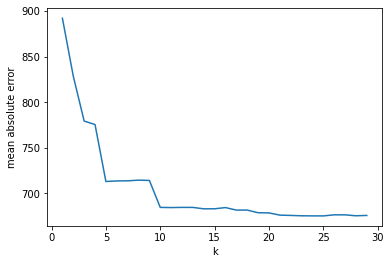

In [119]:
# validation curve
plt.plot(k_list, test_maes)
plt.xlabel('k')
plt.ylabel('mean absolute error');

# V. Check Metrics

In [79]:
print('LR training MAE', mean_absolute_error(y_train, model_lr.predict(XT_train)))
print('LR test MAE', mean_absolute_error(y_test, model_lr.predict(XT_test)))

LR training MAE 674.647210201521
LR test MAE 676.6698842687423


In [91]:
print('Ridge training MAE', mean_absolute_error(y_train, model_r.predict(XT_train)))
print('Ridge test MAE', mean_absolute_error(y_test, model_r.predict(XT_test)))

Ridge training MAE 674.1794177059528
Ridge test MAE 676.0794870552751


In [114]:
print('LR training MAE', mean_absolute_error(y_train, model_skb_lr.predict(XTT_train)))
print('LR test MAE', mean_absolute_error(y_test, model_skb_lr.predict(XTT_test)))

LR training MAE 683.0500192037675
LR test MAE 684.7771582779793


# Communicate results

[ 1.71091358e+03  4.95363056e+02  1.20592928e+03 -1.31289658e+04
 -1.44009452e+15 -1.44009452e+15 -1.44009452e+15  1.52432758e+02
 -3.34937452e+01 -1.50918808e+02  8.85656115e+01  4.34803305e+02
  5.48308064e+01 -1.06818643e+02 -9.20410471e+01  1.12491629e+02
 -8.99737048e+01  4.60897260e+02 -1.66473106e+02 -8.34567573e+01
  2.60092852e+02 -2.99321899e+02 -1.76518769e+01  6.88900389e+01
 -1.36107731e+02  1.65946035e+02  1.44395288e+02  1.50627764e+02
 -2.05363615e+01  1.71471677e+02 -1.56703208e+02]
-----------
['bathrooms', 'bedrooms', 'latitude', 'longitude', 'interest_level_high', 'interest_level_medium', 'interest_level_low', 'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed', 'doorman', 'dishwasher', 'no_fee', 'laundry_in_building', 'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck', 'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony', 'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft', 'garden_patio', 'wheelchair_access', 'common_

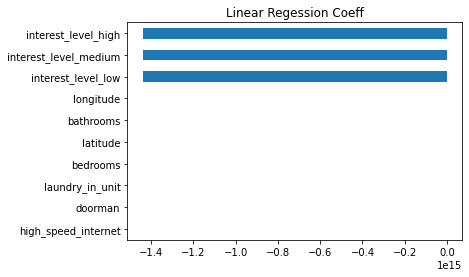

In [93]:
coefficients = model_lr.coef_
print(coefficients)
print('-----------')

features = ohe.get_feature_names()
print(features)
print('-----------')

feat_importance = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_importance

feat_importance.tail(10).plot(kind='barh');
plt.title('Linear Regession Coeff');

[  1711.07932989    494.36491889   1070.35252621 -12621.28559662
   -308.25485765    -99.29376807    407.54862574    152.7817403
    -35.224069     -149.96171715     91.21918526    439.62501791
     57.22679625   -107.43784493    -90.7021951     114.74138744
    -89.05714816    462.83207454   -165.83316842    -84.43847345
    257.21589025   -297.66723512    -18.20156412     69.13425412
   -135.77542974    167.514347      141.6628534     153.39842565
    -20.54169696    167.948852     -153.41746194]
-----------
['bathrooms', 'bedrooms', 'latitude', 'longitude', 'interest_level_high', 'interest_level_medium', 'interest_level_low', 'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed', 'doorman', 'dishwasher', 'no_fee', 'laundry_in_building', 'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck', 'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony', 'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft', 'garden_patio', 'wheelchair_access', 'common_o

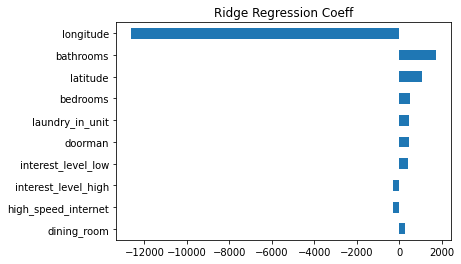

In [97]:
coefficients = model_r.coef_
print(coefficients)
print('-----------')

features = ohe.get_feature_names()
print(features)
print('-----------')

feat_importance = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_importance

feat_importance.tail(10).plot(kind='barh');
plt.title('Ridge Regression Coeff');

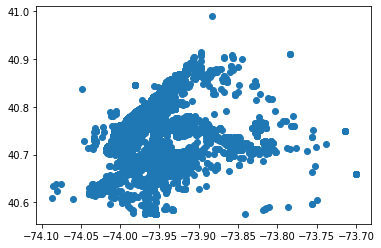

In [96]:
plt.scatter(df['longitude'], df['latitude']);
# as longitude increases you move away from manhatten and thus the price decreases 